## Session 10 - Image search with VGG16 and K-Nearest Neighbours

In [44]:
# base tools
import os, sys
sys.path.append(os.path.join(".."))

# data analysis
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm # Create progress bars for for loops, like tensor flow does.

# tensorflow
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import (load_img, 
                                                  img_to_array)
from tensorflow.keras.applications.vgg16 import (VGG16, 
                                                 preprocess_input)
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd

## Helper functions

Q: What kind of preprocessing am I doing here? Why do you think I'm doing it?

In [2]:
def extract_features(img_path, model):
    """
    Extract features from image data using pretrained model (e.g. VGG16)
    """
    # Define input image shape - remember we need to reshape
    input_shape = (224, 224, 3)
    # load image from file path
    img = load_img(img_path, target_size=(input_shape[0], 
                                          input_shape[1]))
    # convert to array
    img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # preprocess image - see last week's notebook
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(preprocessed_img)
    # flatten
    flattened_features = features.flatten()
    # normalise features
    normalized_features = flattened_features / norm(features) # getting norm from numpy 
    #return flattened_features
    return normalized_features
    # SHould return normalized_features not falttened 

# Image search

## Load VGG16

In [5]:
model = VGG16(weights='imagenet', 
              include_top=False, # dont include classifiers.
              pooling='avg',
              input_shape=(224, 224, 3))

## Extract features from single image

In [6]:
features = extract_features('../data/img/florence.jpg', model)

1/1 [==============================] - 0s 234ms/step


## Iterate over folder

In [7]:
# path to the datasets
root_dir = os.path.join("..", "..", "..", "431824", "flowers")
filenames = [root_dir + "/" + name for name in sorted(os.listdir(root_dir))] # list comprehension.
# For every file in root_dir, get the list of all image names, sort them, combine them with root dir.
print(filenames)

['../../../431824/flowers/image_0001.jpg', '../../../431824/flowers/image_0002.jpg', '../../../431824/flowers/image_0003.jpg', '../../../431824/flowers/image_0004.jpg', '../../../431824/flowers/image_0005.jpg', '../../../431824/flowers/image_0006.jpg', '../../../431824/flowers/image_0007.jpg', '../../../431824/flowers/image_0008.jpg', '../../../431824/flowers/image_0009.jpg', '../../../431824/flowers/image_0010.jpg', '../../../431824/flowers/image_0011.jpg', '../../../431824/flowers/image_0012.jpg', '../../../431824/flowers/image_0013.jpg', '../../../431824/flowers/image_0014.jpg', '../../../431824/flowers/image_0015.jpg', '../../../431824/flowers/image_0016.jpg', '../../../431824/flowers/image_0017.jpg', '../../../431824/flowers/image_0018.jpg', '../../../431824/flowers/image_0019.jpg', '../../../431824/flowers/image_0020.jpg', '../../../431824/flowers/image_0021.jpg', '../../../431824/flowers/image_0022.jpg', '../../../431824/flowers/image_0023.jpg', '../../../431824/flowers/image_00

__Extract features for each image__

In [ ]:
feature_list = []
for i in tqdm(range(len(filenames)), position = 0, leave = True): # for every image in the filenames (images). 
    # with tqdm set a progress bar 
    # REmove notebook - position - leave
    feature_list.append(extract_features(filenames[i], model))

## Nearest neighbours

Once we have our *database* of extracted embeddings, we can then use K-Nearest Neighbours to find similar images.

In [10]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10, # find 10 closet 
                             algorithm='brute', # use bruteforce algoritm 
                             metric='cosine').fit(feature_list) # use cosine  
                             #fit it to feature list.

__Calculate nearest neighbours for target__

In [40]:
chosen_image = [feature_list[251]]
distances, indices = neighbors.kneighbors(chosen_image) # on image 250. 
# first output  = cosine similarity 
# Second output = indicies of the images. 

__Save indices, print data__

In [41]:
idxs = [] # five closet images.
for i in range(1,6):
    print(distances[0][i], indices[0][i])
    idxs.append(indices[0][i])

0.20468313 240
0.22691089 340
0.23347372 244
0.23413253 243
0.24009049 245


In [50]:
filepaths = []
for idx in idxs:
    filepaths.append(filenames[idx])
print(filepaths)

['../../../431824/flowers/image_0241.jpg', '../../../431824/flowers/image_0341.jpg', '../../../431824/flowers/image_0245.jpg', '../../../431824/flowers/image_0244.jpg', '../../../431824/flowers/image_0246.jpg']


In [53]:
# Create a dictionary with keys 'Filepath' and 'Distance'
data = {'Filepath': filepaths, 'Distance': distances[0][1:6]} # excluding the distance to the chosen image itself
# Create a DataFrame using the dictionary
df = pd.DataFrame(data)
df

,Filepath,Distance
0,../../../431824/flowers/image_0241.jpg,0.204683
1,../../../431824/flowers/image_0341.jpg,0.226911
2,../../../431824/flowers/image_0245.jpg,0.233474
3,../../../431824/flowers/image_0244.jpg,0.234133
4,../../../431824/flowers/image_0246.jpg,0.240090


__Plot target image__

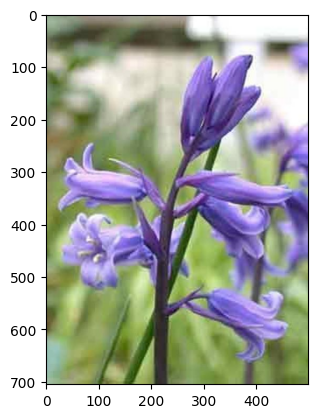

In [24]:
plt.imshow(mpimg.imread(filenames[241]))

__Plot close images__

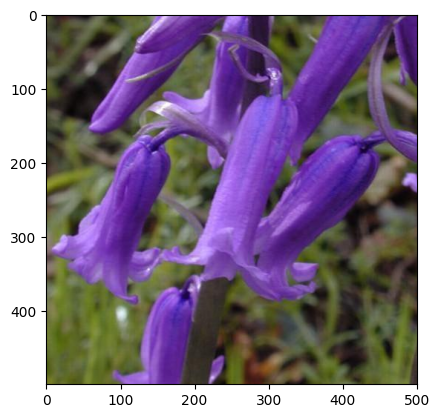

In [25]:
plt.imshow(mpimg.imread(filenames[250]))

__Plot target and top 3 closest together__

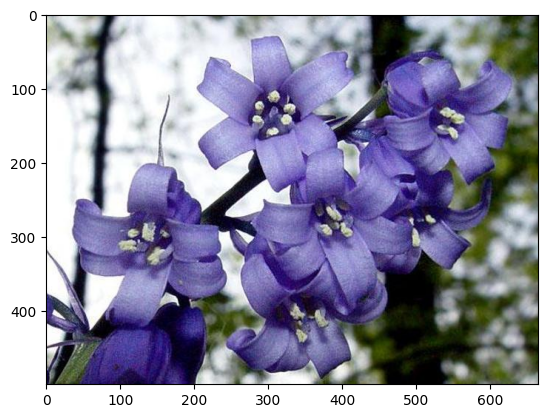

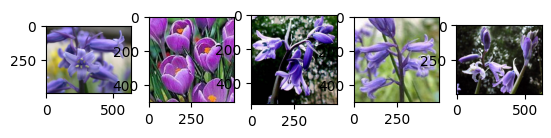

In [36]:
# plt target
plt.imshow(mpimg.imread(filenames[251]))

# plot 3 most similar
f, axarr = plt.subplots(1,5)
axarr[0].imshow(mpimg.imread(filenames[idxs[0]]))
axarr[1].imshow(mpimg.imread(filenames[idxs[1]]))
axarr[2].imshow(mpimg.imread(filenames[idxs[2]]))
axarr[3].imshow(mpimg.imread(filenames[idxs[3]]))
axarr[4].imshow(mpimg.imread(filenames[idxs[4]]))

## Simple style transfer

__Load a quick style transfer model from TF Hub__

You can find more details [here](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)

# Load TF-Hub module.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [24]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle) # Like huggingface but from tensorflow

__Load the content image and the style image__

In [25]:
content_image = st_load("../data/img/florence.jpg")
style_image = st_load("../data/img/starry_night.jpg")

NameError: name 'st_load' is not defined

__Process using the model__

In [ ]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

__Show content, style, and stylized image__

In [ ]:
show_n([content_image, style_image, stylized_image], 
       titles=['Original content image', 'Style image', 'Stylized image'])

### Task1 
- Run this same pipeline on the Indo Fashion dataset. How does it perform?

### Task 2
- Take the code in this notebook and turn it into a Python script. You can then add this to the repo for your Assignment 1 solution for creating doing image search
  - I.e. your Assignment 1 repo would contain both code for image search using colour histograms *and* for image search using a pretrained CNN.

### Task 3 
- Continue working on Assignment 3 in-class just now.